In [1]:
try:
    from rich import load_ipython_extension
    %load_ext rich
except ImportError:
    try:
        from rich import pretty
        pretty.install()
    except ImportError:
        pass

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance

Using the cleaned dataset created in assignment 1

In [3]:
data = pd.read_csv("../data/manipulated_data.csv")
data

,sex,age,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
0,Man,16-19,TOT,2018,547.9,38091,Stockholm,primary/lower secondary
1,Man,16-19,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,16-19,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,16-19,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,16-19,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...,...
409255,Woman,65-69,80-99,2012,0.9,10,Norrbotten,unknown
409256,Woman,70-75,TOT,2012,2.4,36,Norrbotten,unknown
409257,Woman,70-75,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,70-75,1-19,2012,0.1,6,Norrbotten,unknown


I will try to classify which age the test instances has based on their features.

In [4]:
data["age"].unique().tolist()

['16-19', '20-29', '30-39', '40-49', '50-59', '60-64', '65-69', '70-75']

Number of instances for each age bin

In [46]:
data["age"].value_counts()


age
30-39    58938
40-49    57395
20-29    57333
50-59    55641
60-64    53044
65-69    52566
70-75    50595
16-19    23748
Name: count, dtype: int64

In [5]:
labels = data[["age"]]
labels

,age
0,16-19
1,16-19
2,16-19
3,16-19
4,16-19
...,...
409255,65-69
409256,70-75
409257,70-75
409258,70-75


I will use all features in the first experiment.

In [6]:
features = data.drop(columns="age")
features

,sex,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
0,Man,TOT,2018,547.9,38091,Stockholm,primary/lower secondary
1,Man,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...
409255,Woman,80-99,2012,0.9,10,Norrbotten,unknown
409256,Woman,TOT,2012,2.4,36,Norrbotten,unknown
409257,Woman,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,1-19,2012,0.1,6,Norrbotten,unknown


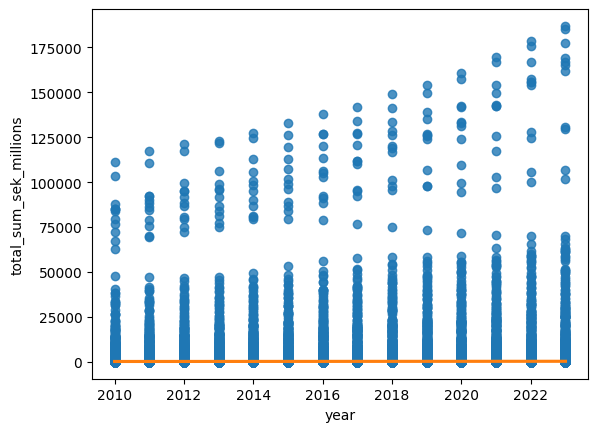

In [47]:
orange = sns.color_palette()[1]
sns.regplot(
    data=data,
    x="year",
    y="total_sum_sek_millions",
    ci=False,
    line_kws={"color": orange},
);

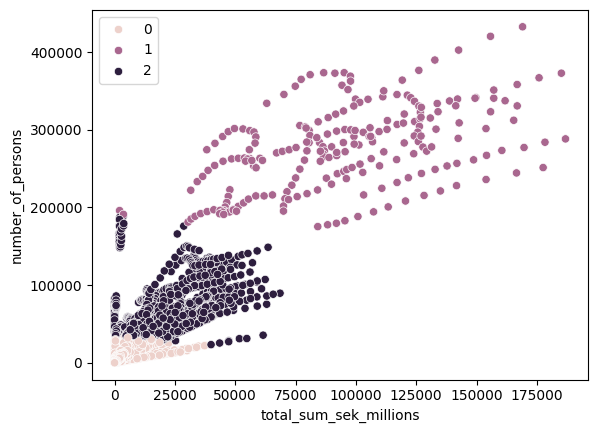

In [10]:
model = KMeans(n_clusters=3, random_state=42, n_init=10)
X = data[["level_of_education", "age"]]
X = data[["total_sum_sek_millions", "number_of_persons"]]
y = model.fit_predict(X)

sns.scatterplot(x=data["total_sum_sek_millions"], y=data["number_of_persons"], hue=y);

<Axes: xlabel='total_sum_sek_millions', ylabel='number_of_persons'>

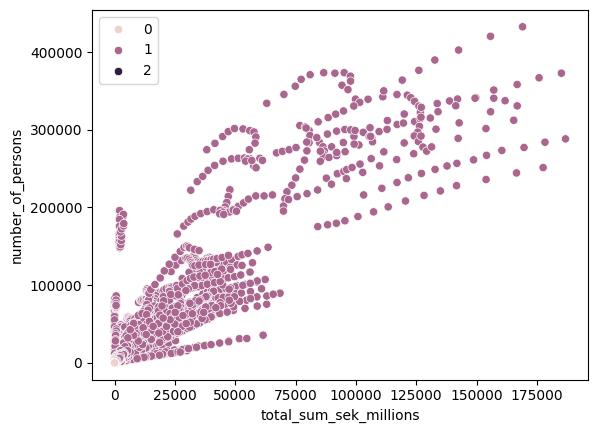

In [ ]:
model = GMM(n_components=3, random_state=0)
y = model.fit_predict(X)
sns.scatterplot(x=data["total_sum_sek_millions"], y=data["number_of_persons"], hue=y);

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, random_state=42, shuffle=True)

X_train

,sex,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
252845,Man,60-79,2015,16.0,231,Kronoberg,post-secondary
285224,Woman,1000+,2021,286.7,219,Skåne,upper secondary
326532,Woman,160-179,2010,28.7,170,Norrbotten,post-secondary
74032,Man,1-19,2023,0.2,21,Örebro,unknown
171175,Man,80-99,2014,10.3,107,Södermanland,unknown
...,...,...,...,...,...,...,...
259178,Man,240-259,2015,34.1,136,Halland,post-secondary
365838,Man,340-359,2022,1.1,3,Blekinge,unknown
131932,Man,800-999,2020,3.4,4,Dalarna,primary/lower secondary
146867,Man,360-379,2017,166.5,450,Kronoberg,upper secondary


In [13]:
y_train

,age
252845,20-29
285224,50-59
326532,20-29
74032,20-29
171175,20-29
...,...
259178,30-39
365838,20-29
131932,30-39
146867,20-29


Catagorical features

In [14]:
cat_features = features.drop(columns=["year", "total_sum_sek_millions", "number_of_persons"]).columns.to_list()

cat_features

['sex', 'income_bracket', 'region_name', 'level_of_education']

In [15]:
HGB_clf = HistGradientBoostingClassifier(
    loss="log_loss", learning_rate=0.1, max_iter=100, categorical_features=cat_features, l2_regularization=0, validation_fraction=0.1, n_iter_no_change=10, verbose=1, random_state=42
).fit(X=X_train, y=y_train)

Binning 0.014 GB of training data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.049 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.600 s, (24800 total leaves)
Time spent computing histograms: 2.444s
Time spent finding best splits:  0.402s
Time spent applying splits:      1.692s
Time spent predicting:           0.384s


In [16]:
y_pred = HGB_clf.predict(X=X_test)

In [17]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.44525892260828487

In [18]:
HGB_clf.score(X=X_test, y=y_test)

0.44525892260828487

In [19]:
f1_score(y_test, y_pred, labels=HGB_clf.classes_, average=None)


array([0.76869111, 0.52937755, 0.38484177, 0.30981566, 0.35612181,
       0.47356723, 0.39830461, 0.5042039 ])

<Axes: >

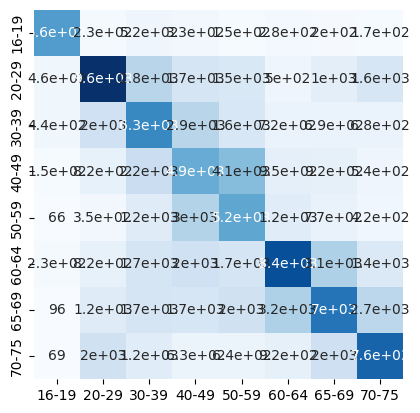

In [ ]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat.T,
    square=True,
    annot=True,
    cbar=False,
    xticklabels=HGB_clf.classes_,
    yticklabels=HGB_clf.classes_,
    cmap="Blues",
);

In [21]:
scores = cross_val_score(HGB_clf, features, labels, cv=5)
scores.mean()

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.042 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.856 s, (24800 total leaves)
Time spent computing histograms: 3.153s
Time spent finding best splits:  0.468s
Time spent applying splits:      2.210s
Time spent predicting:           0.518s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.047 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.810 s, (24800 total leaves)
Time spent computing histograms: 3.145s
Time spent finding best splits:  0.463s
Time spent applying splits:      2.172s
Time spent predicting:           0.509s
Binning 0.017 GB of training data: 0.046 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 11.325 s, (24800 total leaves)
Time spent computing histograms: 3.385s
Time spent finding best splits:  0.520s
Time spent applying splits:      2.278s
Time spent predicting:           0.529s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.046 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.560 s, (24800 total leaves)
Time spent computing histograms: 3.119s
Time spent finding best splits:  0.460s
Time spent applying splits:      2.134s
Time spent predicting:           0.504s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.060 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.856 s, (24800 total leaves)
Time spent computing histograms: 3.162s
Time spent finding best splits:  0.474s
Time spent applying splits:      2.219s
Time spent predicting:           0.514s


0.4342300737917217

Tuning

In [31]:
# Parameter Suggested Range:

learning_rate = [0.01, 0.05, 0.1, 0.2]
max_iter = [100, 300, 500, 1000]
max_leaf_nodes = [10, 20, 31, 50, 100] # default = 31
max_depth = [3, 5, 8, None]
min_samples_leaf = [1, 5, 10, 20, 50]
l2_regularization = [0, 1e-3, 1e-2, 1e-1, 1]
max_features = [0.3, 0.5, 0.7, 1.0]
validation_fraction = [0.1, 0.2]
n_iter_no_change = [5, 10, 20]

In [ ]:
# param_grid = [
#     {"learning_rate": learning_rate, "max_iter": max_iter, "max_leaf_nodes": max_leaf_nodes, "max_depth": max_depth, "min_samples_leaf": min_samples_leaf, "l2_regularization": l2_regularization, "max_features": max_features, "validation_fraction": validation_fraction, "n_iter_no_change": n_iter_no_change}
# ]

param_grid = [
    {
        "learning_rate": learning_rate,
        # "max_iter": max_iter,
        "max_leaf_nodes": max_leaf_nodes,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "l2_regularization": l2_regularization,
        # "max_features": max_features,
        # "validation_fraction": validation_fraction,
        # "n_iter_no_change": n_iter_no_change,
    }
]

grid = GridSearchCV(HistGradientBoostingClassifier(verbose=1), param_grid, scoring="accuracy", verbose=1)
grid.fit(X_train, y_train)
grid.best_params_

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring="f1_macro",  # or 'balanced_accuracy'
    cv=cv,
    n_jobs=-1,
    random_state=42,
)
search.fit(X, y)

In [34]:


HGB_clf = HistGradientBoostingClassifier(
    loss="log_loss", learning_rate=0.1, max_iter=100, categorical_features=cat_features, l2_regularization=0, validation_fraction=0.1, n_iter_no_change=10, verbose=1, random_state=42
)
clf = RandomizedSearchCV(HGB_clf, param_grid, random_state=0, verbose=1)
search = clf.fit(features, labels)
search.best_params_

Binning 0.017 GB of training data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.096 s
Binning 0.002 GB of validation data: 0.018 s
Fitting gradient boosted rounds:
Fit 800 trees in 7.528 s, (16000 total leaves)
Time spent computing histograms: 2.098s
Time spent finding best splits:  0.235s
Time spent applying splits:      1.369s
Time spent predicting:           0.354s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.056 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 7.897 s, (16000 total leaves)
Time spent computing histograms: 2.213s
Time spent finding best splits:  0.247s
Time spent applying splits:      1.437s
Time spent predicting:           0.364s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.049 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.067 s, (16000 total leaves)
Time spent computing histograms: 2.249s
Time spent finding best splits:  0.274s
Time spent applying splits:      1.490s
Time spent predicting:           0.381s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.045 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.111 s, (16000 total leaves)
Time spent computing histograms: 2.541s
Time spent finding best splits:  0.287s
Time spent applying splits:      1.743s
Time spent predicting:           0.422s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.047 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.264 s, (16000 total leaves)
Time spent computing histograms: 2.643s
Time spent finding best splits:  0.303s
Time spent applying splits:      1.682s
Time spent predicting:           0.431s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.045 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.551 s, (16000 total leaves)
Time spent computing histograms: 2.742s
Time spent finding best splits:  0.294s
Time spent applying splits:      1.843s
Time spent predicting:           0.468s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.560 s, (16000 total leaves)
Time spent computing histograms: 2.787s
Time spent finding best splits:  0.293s
Time spent applying splits:      1.880s
Time spent predicting:           0.477s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.046 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.029 s, (16000 total leaves)
Time spent computing histograms: 2.910s
Time spent finding best splits:  0.303s
Time spent applying splits:      1.969s
Time spent predicting:           0.499s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.043 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.631 s, (16000 total leaves)
Time spent computing histograms: 2.841s
Time spent finding best splits:  0.290s
Time spent applying splits:      1.909s
Time spent predicting:           0.471s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.044 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.419 s, (16000 total leaves)
Time spent computing histograms: 3.159s
Time spent finding best splits:  0.313s
Time spent applying splits:      2.020s
Time spent predicting:           0.491s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.058 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.000 s, (8000 total leaves)
Time spent computing histograms: 2.980s
Time spent finding best splits:  0.212s
Time spent applying splits:      1.692s
Time spent predicting:           0.456s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.050 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.721 s, (8000 total leaves)
Time spent computing histograms: 2.602s
Time spent finding best splits:  0.175s
Time spent applying splits:      1.511s
Time spent predicting:           0.424s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.047 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.069 s, (8000 total leaves)
Time spent computing histograms: 2.693s
Time spent finding best splits:  0.182s
Time spent applying splits:      1.592s
Time spent predicting:           0.440s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.046 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.854 s, (8000 total leaves)
Time spent computing histograms: 2.634s
Time spent finding best splits:  0.174s
Time spent applying splits:      1.527s
Time spent predicting:           0.430s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.051 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.540 s, (8000 total leaves)
Time spent computing histograms: 2.527s
Time spent finding best splits:  0.170s
Time spent applying splits:      1.475s
Time spent predicting:           0.413s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.046 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 7.919 s, (6400 total leaves)
Time spent computing histograms: 2.140s
Time spent finding best splits:  0.089s
Time spent applying splits:      1.385s
Time spent predicting:           0.409s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.057 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 7.632 s, (6397 total leaves)
Time spent computing histograms: 2.064s
Time spent finding best splits:  0.084s
Time spent applying splits:      1.347s
Time spent predicting:           0.393s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.274 s, (6398 total leaves)
Time spent computing histograms: 2.227s
Time spent finding best splits:  0.094s
Time spent applying splits:      1.392s
Time spent predicting:           0.423s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.042 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.205 s, (6397 total leaves)
Time spent computing histograms: 2.217s
Time spent finding best splits:  0.094s
Time spent applying splits:      1.422s
Time spent predicting:           0.420s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.629 s, (6400 total leaves)
Time spent computing histograms: 2.366s
Time spent finding best splits:  0.107s
Time spent applying splits:      1.568s
Time spent predicting:           0.440s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.051 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 11.938 s, (24800 total leaves)
Time spent computing histograms: 3.291s
Time spent finding best splits:  0.318s
Time spent applying splits:      2.839s
Time spent predicting:           0.719s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.049 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 11.566 s, (24794 total leaves)
Time spent computing histograms: 3.180s
Time spent finding best splits:  0.296s
Time spent applying splits:      2.728s
Time spent predicting:           0.680s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.052 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 11.238 s, (24763 total leaves)
Time spent computing histograms: 3.121s
Time spent finding best splits:  0.290s
Time spent applying splits:      2.622s
Time spent predicting:           0.654s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.047 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.884 s, (24800 total leaves)
Time spent computing histograms: 2.684s
Time spent finding best splits:  0.247s
Time spent applying splits:      2.351s
Time spent predicting:           0.631s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.829 s, (24800 total leaves)
Time spent computing histograms: 2.713s
Time spent finding best splits:  0.246s
Time spent applying splits:      2.364s
Time spent predicting:           0.619s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.040 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.154 s, (24800 total leaves)
Time spent computing histograms: 2.585s
Time spent finding best splits:  0.349s
Time spent applying splits:      1.808s
Time spent predicting:           0.446s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.454 s, (24800 total leaves)
Time spent computing histograms: 2.685s
Time spent finding best splits:  0.369s
Time spent applying splits:      1.881s
Time spent predicting:           0.448s
Binning 0.017 GB of training data: 0.040 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.980 s, (24800 total leaves)
Time spent computing histograms: 2.538s
Time spent finding best splits:  0.359s
Time spent applying splits:      1.770s
Time spent predicting:           0.438s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.042 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.299 s, (24788 total leaves)
Time spent computing histograms: 2.624s
Time spent finding best splits:  0.360s
Time spent applying splits:      1.841s
Time spent predicting:           0.446s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.066 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.765 s, (24798 total leaves)
Time spent computing histograms: 3.016s
Time spent finding best splits:  0.426s
Time spent applying splits:      2.094s
Time spent predicting:           0.506s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.556 s, (16000 total leaves)
Time spent computing histograms: 2.672s
Time spent finding best splits:  0.226s
Time spent applying splits:      2.081s
Time spent predicting:           0.510s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.899 s, (16000 total leaves)
Time spent computing histograms: 2.488s
Time spent finding best splits:  0.205s
Time spent applying splits:      1.929s
Time spent predicting:           0.507s
Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.040 s, (15996 total leaves)
Time spent computing histograms: 2.816s
Time spent finding best splits:  0.232s
Time spent applying splits:      2.173s
Time spent predicting:           0.548s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.666 s, (16000 total leaves)
Time spent computing histograms: 2.679s
Time spent finding best splits:  0.219s
Time spent applying splits:      2.124s
Time spent predicting:           0.528s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.040 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.723 s, (16000 total leaves)
Time spent computing histograms: 2.412s
Time spent finding best splits:  0.201s
Time spent applying splits:      1.909s
Time spent predicting:           0.501s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.042 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.455 s, (16000 total leaves)
Time spent computing histograms: 2.782s
Time spent finding best splits:  0.312s
Time spent applying splits:      1.838s
Time spent predicting:           0.465s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.046 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.948 s, (16000 total leaves)
Time spent computing histograms: 2.917s
Time spent finding best splits:  0.325s
Time spent applying splits:      1.921s
Time spent predicting:           0.494s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.046 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.919 s, (16000 total leaves)
Time spent computing histograms: 3.286s
Time spent finding best splits:  0.374s
Time spent applying splits:      2.149s
Time spent predicting:           0.546s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.060 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.550 s, (16000 total leaves)
Time spent computing histograms: 2.798s
Time spent finding best splits:  0.314s
Time spent applying splits:      1.893s
Time spent predicting:           0.484s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.049 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.289 s, (16000 total leaves)
Time spent computing histograms: 3.025s
Time spent finding best splits:  0.336s
Time spent applying splits:      2.014s
Time spent predicting:           0.507s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.047 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.844 s, (15986 total leaves)
Time spent computing histograms: 2.746s
Time spent finding best splits:  0.231s
Time spent applying splits:      2.116s
Time spent predicting:           0.532s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.045 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.781 s, (15997 total leaves)
Time spent computing histograms: 2.742s
Time spent finding best splits:  0.225s
Time spent applying splits:      2.094s
Time spent predicting:           0.509s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.040 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.344 s, (15970 total leaves)
Time spent computing histograms: 2.687s
Time spent finding best splits:  0.209s
Time spent applying splits:      1.993s
Time spent predicting:           0.506s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.085 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 11.502 s, (15999 total leaves)
Time spent computing histograms: 3.338s
Time spent finding best splits:  0.287s
Time spent applying splits:      2.462s
Time spent predicting:           0.562s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.048 s
Binning 0.002 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.753 s, (15995 total leaves)
Time spent computing histograms: 2.681s
Time spent finding best splits:  0.218s
Time spent applying splits:      2.069s
Time spent predicting:           0.512s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.425 s, (24911 total leaves)
Time spent computing histograms: 2.800s
Time spent finding best splits:  0.264s
Time spent applying splits:      2.472s
Time spent predicting:           0.600s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.040 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.933 s, (24813 total leaves)
Time spent computing histograms: 2.707s
Time spent finding best splits:  0.253s
Time spent applying splits:      2.357s
Time spent predicting:           0.596s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.048 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.070 s, (24816 total leaves)
Time spent computing histograms: 2.697s
Time spent finding best splits:  0.251s
Time spent applying splits:      2.347s
Time spent predicting:           0.601s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.040 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.777 s, (24816 total leaves)
Time spent computing histograms: 2.650s
Time spent finding best splits:  0.250s
Time spent applying splits:      2.333s
Time spent predicting:           0.588s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.044 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.750 s, (24901 total leaves)
Time spent computing histograms: 2.860s
Time spent finding best splits:  0.278s
Time spent applying splits:      2.519s
Time spent predicting:           0.611s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.021 GB of training data: 0.048 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 12.275 s, (24800 total leaves)
Time spent computing histograms: 3.575s
Time spent finding best splits:  0.408s
Time spent applying splits:      2.387s
Time spent predicting:           0.595s



{
    'min_samples_leaf': 20,
    'max_leaf_nodes': 31,
    'max_depth': 8,
    'learning_rate': 0.2,
    'l2_regularization': 0.001
}

In [36]:
search.best_estimator_

HistGradientBoostingClassifier(categorical_features=['sex', 'income_bracket',
                                                     'region_name',
                                                     'level_of_education'],
                               l2_regularization=0.001, learning_rate=0.2,
                               max_depth=8, random_state=42, verbose=1)

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa

# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

In [37]:
model = search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

Binning 0.014 GB of training data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.044 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.407 s, (24800 total leaves)
Time spent computing histograms: 1.810s
Time spent finding best splits:  0.258s
Time spent applying splits:      1.235s
Time spent predicting:           0.295s


0.4622733714509114

In [38]:
scores = cross_val_score(model, features, labels, cv=5)
scores.mean()

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.038 s
Binning 0.002 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
Fit 800 trees in 7.263 s, (24800 total leaves)
Time spent computing histograms: 1.991s
Time spent finding best splits:  0.256s
Time spent applying splits:      1.355s
Time spent predicting:           0.338s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.044 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 10.447 s, (24800 total leaves)
Time spent computing histograms: 2.987s
Time spent finding best splits:  0.396s
Time spent applying splits:      2.107s
Time spent predicting:           0.493s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.042 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.543 s, (24800 total leaves)
Time spent computing histograms: 2.717s
Time spent finding best splits:  0.365s
Time spent applying splits:      1.884s
Time spent predicting:           0.457s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.049 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.235 s, (24788 total leaves)
Time spent computing histograms: 2.567s
Time spent finding best splits:  0.349s
Time spent applying splits:      1.832s
Time spent predicting:           0.443s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.042 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.084 s, (24798 total leaves)
Time spent computing histograms: 2.549s
Time spent finding best splits:  0.340s
Time spent applying splits:      1.805s
Time spent predicting:           0.448s


0.4519156526413527

In [40]:
pi = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
pi["importances_mean"]


array([0.06652495, 0.23096157, 0.04388245, 0.18233071, 0.25580479,
       0.18336347, 0.1903859 ])

In [ ]:
pd.DataFrame([features.columns, pi["importances_mean"]]).T.set_index(0)

,1
0,
sex,0.066525
income_bracket,0.230962
year,0.043882
total_sum_sek_millions,0.182331
number_of_persons,0.255805
region_name,0.183363
level_of_education,0.190386


**3. Change your train/test data** (e.g. `X_train`, `X_test`) **to only include the _two most important features_.** Then retrain the model with that & evaluate it again. Did the accuracy score change?

**4. Do the same thing, but train the model on the _two least important features only_.** What accuracy score do you expect? See if the result matches your expectation.

**6. Which of our measurement variables are _normally distributed_?** Checking for a normal distribution is useful, because it is often a requirement for using other metrics that the data is normally distributed.

In [44]:
pg.normality(data)

/home/joel/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 409260.
  res = hypotest_fun_out(*samples, **kwds)


,W,pval,normal
year,0.943776,3.137042e-123,False
total_sum_sek_millions,0.063580,6.872029e-219,False
number_of_persons,0.077122,2.533260e-218,False


**7. Which of the measurement variables are _correlated_?** Perform a pairwise correlation analysis with all the columns of our dataframe. Use Pearson correlation if the variables are normally distributed, and Spearman correlation if not.

In [45]:
pg.pairwise_corr(data, method="pearson")

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,year,total_sum_sek_millions,pearson,two-sided,409260,0.011944,"[0.01, 0.02]",2.156454e-14,9.331e+09,1.000000
1,year,number_of_persons,pearson,two-sided,409260,-0.001386,"[-0.0, 0.0]",3.752904e-01,0.003,0.143765
2,total_sum_sek_millions,number_of_persons,pearson,two-sided,409260,0.916260,"[0.92, 0.92]",0.000000e+00,inf,1.000000


**8. Make a new Pandas DataFrame with "classifier correctness" labels.** This DataFrame should have:

- One **column per classifier**, e.g. the "good" classifier from Q3, the "bad" classifier from Q4, and the "majority" classifier from Q5.
- One **row per instance in your test set**.
- A value of **`True` or `False` in each cell**, depending on whether the classifier _(column)_ correctly classified the instance _(row)_ or not.

Your resulting DataFrame could look something like this:

|       | **good** | **bad**  | **majority** |
|-------|----------|----------|--------------|
| **0** | True     | False    | False        |
| **1** | True     | False    | False        |
| **2** | True     | True     | True         |
| ...   | ...      | ...      | ...          |

In [ ]:
df_eval = pd.DataFrame(
    np.transpose([y_pred_good == y_test, y_pred_bad == y_test, y_majority == y_test]),
    columns=["good", "bad", "majority"],
)
df_eval

**9. Is the "bad" model (from Q4) still significantly better than the "majority" class model (from Q5)?**

We want to answer this question by using **McNemar's test,** using a significance level of $0.05$.  This means that if McNemar's test gives us a $p$-value $< 0.05$, we accept that there is a significant difference between our two classifiers.  If you use [Pingouin's implementation of McNemar's test](https://pingouin-stats.org/generated/pingouin.chi2_mcnemar.html), you will find that the DataFrame from Q6 is exactly what we need to use with Pingouin!

**11. Perform a principal component analysis (PCA) to map the GloVe vectors into 2-dimensional space.** Two dimensions are a common choice to make them suitable for visualization.

If you are using Scikit-learn to do this, you will find that the 2-dimensional vectors are returned as a NumPy array.

- **Also merge this back into a DataFrame that has the actual words as an index again**, just like above!

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
glove_pca = pca.fit_transform(glove)
glove_pca

In [ ]:
glove_pca = pd.DataFrame(glove_pca)
glove_pca["word"] = glove.index
glove_pca = glove_pca.set_index("word")
glove_pca

In [ ]:
def plot_words(df):
    """This function takes a DataFrame with a word index
    and plots some chosen example words of different categories."""

    word_cats = {
        "food": ["apple", "orange", "lemon", "tomato", "potato", "chocolate", "bread", "butter"],
        "transport": ["car", "train", "rail", "plane", "bike", "boat", "ship", "foot"],
        "pronouns": ["he", "she", "it", "they", "them", "you", "your", "us"],
    }
    fig, ax = plt.subplots()
    pal = sns.color_palette("bright")
    for i, (category, words) in enumerate(word_cats.items()):
        for word in words:
            pos = df.loc[word].iloc[0], df.loc[word].iloc[1]
            ax.scatter(*pos, color=pal[i])
            ax.annotate(word, pos, color=pal[i])